In [1]:
# 1. Tạo class Dataset để fetch dữ liệu
# 2. Khảo sát phân phối của dữ liệu và chuẩn hóa trọng số để cân chỉnh mức độ phụ thuộc
# 3. Cắt nhỏ dataset ra làm nhiều phần để train dần và vẫn đảm bảo phân bố của dữ liệu
# 4. Tạo Dataloader cho tập train và valid
# 5. Xây dựng mô hình, hàm thất thoát, bộ tối ưu và chọn siêu tham số
# 6. Tạo cái j đó để theo dõi đánh giá và lưu lại quá trình huấn luyện mô hình
# 7. Huấn luyện mô hình
# 8. Đánh giá mô hình

## 0. Import configuration

In [131]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import yaml
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import os
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix

import time
import copy
import seaborn as sns

with open("config/config.yaml", "r") as f:
    conf = yaml.safe_load(f)

x_train_path = conf['dataset']['x_train']
y_train_path = conf['dataset']['y_train']

x_valid_path = conf['dataset']['x_valid']
y_valid_path = conf['dataset']['y_valid']

x_test_path = conf['dataset']['x_test']
y_test_path = conf['dataset']['y_test']

batch_size = conf['parameter']['batch_size']
learning_rate = conf['parameter']['learning_rate']
epochs = conf['parameter']['epochs']
num_chunk = conf['chunk']

## 1. Create Dataset class

In [ ]:
# 1. Create dataset class
class HAM10KDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.labels_df = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

        self.class_cols = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
        # Create a mapping from class name to numerical label
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.class_cols)}

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        # get image
        img_name = self.labels_df.iloc[idx]['image'] + '.jpg'
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        # get numerical label
        encode_label = self.labels_df.iloc[idx][self.class_cols].values
        string_label = self.class_cols[encode_label.argmax()]
        numerical_label = self.class_to_idx[string_label]

        if self.transform:
            image = self.transform(image)

        return image, numerical_label


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_set = HAM10KDataset(
    csv_path=y_train_path,   # CSV
    img_dir=x_train_path,    # thư mục ảnh
    transform=transform
)

valid_set = HAM10KDataset(
    csv_path=y_valid_path,
    img_dir=x_valid_path,
    transform=transform
)

print(f"Kích thước tập train: {len(train_set)}")
print(f"Kích thước tập validation: {len(valid_set)}")

Kích thước tập train: 10015
Kích thước tập validation: 193


## 2. Examine data distribution and Calculate Classes' Weights

In [4]:
y_train_df = train_set.labels_df
class_cols = train_set.class_cols
class_counts = {cls: 0 for cls in class_cols}

for i, row in y_train_df.iterrows():
    for cls in class_cols:
        if row[cls] == 1:
            class_counts[cls] += 1
            break

print(class_counts)

total = len(y_train_df)
num_classes = len(class_cols)

class_weights = []
for cls_name in class_cols:
    count = class_counts[cls_name]
    weight = total / (num_classes * count)
    class_weights.append(weight)

class_weights = np.array(class_weights)
class_weights = class_weights / class_weights.sum() # chuẩn hóa để để đưa vào hàm Focal loss
class_weights

{'MEL': 1113, 'NV': 6705, 'BCC': 514, 'AKIEC': 327, 'BKL': 1099, 'DF': 115, 'VASC': 142}


array([0.03958192, 0.00657042, 0.08570948, 0.13472377, 0.04008614,
       0.3830841 , 0.31024417])

## 3. Chunking Dataset

In [5]:
# Chunking dataset into 10 small subset with the same distribution
labels = np.argmax(train_set.labels_df[train_set.class_cols].values, axis=1)
indices = np.arange(len(train_set))

# Đảm bảo mỗi tập con đều vẫn giữ nguyên phân phối như tập lớn
skf = StratifiedKFold(
    n_splits=num_chunk,
    shuffle=True,
    random_state=1
)

k_chunk_indices = []
for fold_id, (whatisthis, chunk_indices) in enumerate(skf.split(indices, labels)):
    print(f"Chunk {fold_id+1} with {len(chunk_indices)} samples")
    count = Counter(labels[chunk_indices])
    count = {int(k): int(v) for k, v in count.items()}
    print(dict(sorted(count.items())))
    k_chunk_indices.append(chunk_indices)

Chunk 1 with 1002 samples
{0: 111, 1: 671, 2: 52, 3: 32, 4: 110, 5: 12, 6: 14}
Chunk 2 with 1002 samples
{0: 111, 1: 671, 2: 52, 3: 32, 4: 110, 5: 12, 6: 14}
Chunk 3 with 1002 samples
{0: 111, 1: 671, 2: 52, 3: 33, 4: 110, 5: 11, 6: 14}
Chunk 4 with 1002 samples
{0: 111, 1: 671, 2: 51, 3: 33, 4: 110, 5: 11, 6: 15}
Chunk 5 with 1002 samples
{0: 111, 1: 671, 2: 51, 3: 33, 4: 110, 5: 11, 6: 15}
Chunk 6 with 1001 samples
{0: 112, 1: 670, 2: 51, 3: 33, 4: 110, 5: 11, 6: 14}
Chunk 7 with 1001 samples
{0: 112, 1: 670, 2: 51, 3: 33, 4: 110, 5: 11, 6: 14}
Chunk 8 with 1001 samples
{0: 112, 1: 670, 2: 51, 3: 33, 4: 109, 5: 12, 6: 14}
Chunk 9 with 1001 samples
{0: 111, 1: 670, 2: 51, 3: 33, 4: 110, 5: 12, 6: 14}
Chunk 10 with 1001 samples
{0: 111, 1: 670, 2: 52, 3: 32, 4: 110, 5: 12, 6: 14}


## 4. Create DataLoader for train and valid

In [ ]:
valid_loader = DataLoader(valid_set, batch_size = batch_size, shuffle=True)

chunk_loaders = []

for i, chunk_indices in enumerate(k_chunk_indices):
    chunk_subset = Subset(
        train_set,
        chunk_indices
    )

    loader = DataLoader(
        chunk_subset,
        batch_size = batch_size,
        shuffle=True
    )

    chunk_loaders.append(loader)

chunk_loaders

## 5. Define model

### 5.1 Build model

In [7]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()

        # Depthwise convolution
        self.depthwise = nn.Sequential(
            nn.Conv2d(
                in_channels,
                in_channels,
                kernel_size=3,
                stride=stride,
                padding=1,
                groups=in_channels,
                bias=False
            ),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )

        # Pointwise convolution
        self.pointwise = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [8]:
class MobileNetV1(nn.Module):
    def __init__(self, num_classes=7, width_mult=1.0):
        super().__init__()

        def c(ch):
            return int(ch * width_mult)

        self.features = nn.Sequential(
            # Conv 1
            nn.Conv2d(3, c(32), kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(c(32)),
            nn.ReLU(inplace=True),

            # Depthwise blocks
            DepthwiseSeparableConv(c(32),  c(64),  stride=1),
            DepthwiseSeparableConv(c(64),  c(128), stride=2),
            DepthwiseSeparableConv(c(128), c(128), stride=1),
            DepthwiseSeparableConv(c(128), c(256), stride=2),
            DepthwiseSeparableConv(c(256), c(256), stride=1),
            DepthwiseSeparableConv(c(256), c(512), stride=2),

            # 5 × (512 → 512)
            DepthwiseSeparableConv(c(512), c(512), stride=1),
            DepthwiseSeparableConv(c(512), c(512), stride=1),
            DepthwiseSeparableConv(c(512), c(512), stride=1),
            DepthwiseSeparableConv(c(512), c(512), stride=1),
            DepthwiseSeparableConv(c(512), c(512), stride=1),

            DepthwiseSeparableConv(c(512), c(1024), stride=2),
            DepthwiseSeparableConv(c(1024), c(1024), stride=1),
        )

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(c(1024), num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

### 5.2 Loss function

In [9]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha, gamma=2):
        super(FocalLoss, self).__init__()
        self.register_buffer(
            "alpha", torch.tensor(alpha, dtype=torch.float32)
        )
        self.gamma = gamma

    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce)
        alpha_t = self.alpha.to(logits.device)[targets]
        loss = alpha_t * (1 - pt) ** self.gamma * ce
        return loss.mean()

print("FocalLoss class defined.")

FocalLoss class defined.


### 5.3 Model operations

In [10]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    runnning_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for imgs, labels in dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        runnning_loss += loss.item() * imgs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = runnning_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_prediction = 0
    total_samples = 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs.data, 1)

            total_samples += labels.size(0)
            correct_prediction += (preds == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_prediction / total_samples
    return epoch_loss, epoch_acc

print("Training and validation epoch functions defined.")

Training and validation epoch functions defined.


## 6. Creat model checkpoint save/loader + Metrics log

### 6.1 Checkpoints save/loader

In [24]:
from datetime import datetime
import csv, os, json
from sklearn.metrics import f1_score, recall_score

def save_checkpoint(
        model,
        optimizer,
        epoch,
        save_dir
):
    ckpt = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "timestamp": datetime.now().isoformat()
    }

    path = f"{save_dir}/checkpoint/epoch_{epoch:02d}.pt"
    torch.save(ckpt, path)

def load_checkpoint(dir_path, model, optimizer, device):
    ckpt_files = [
        f for f in os.listdir(dir_path)
        if f.endswith(".pt")
    ]

    if len(ckpt_files) != 0:
        
        #Sort theo epoch
        ckpt_files.sort()
        latest_ckpt = ckpt_files[-1]

        ckpt_path = os.path.join(dir_path, latest_ckpt)
        ckpt = torch.load(ckpt_path, map_location=device)

        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])

        start_epoch = ckpt["epoch"] + 1
        
        print(f"[INFO] Resume training from {latest_ckpt}")
        print(f"       Continue with epoch {start_epoch}")
    else:
        print(f"[INFO] No checkpoints found ! Consider start training some..")
        model = None
        optimizer = None
        start_epoch = 0

    return model, optimizer, start_epoch

### 6.2 Metrics log

In [25]:
def log_to_csv(path, row):
    write_header = not os.path.exists(path)

    with open(path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=row.keys())
        if write_header:
            writer.writeheader()
        writer.writerow(row)

## 7. Train mô hình thôi

### 7.1 Khởi tạo tham số training

In [36]:
# Thiết lập mô hình
device = "cuda" if torch.cuda.is_available() else "cpu"

resume_ckpt_path = r"experiments\mobilenetv1_ham10k\checkpoint"

model = MobileNetV1(num_classes=7).to(device)
criterion = FocalLoss(alpha=class_weights, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

model, optimizer, start_epoch = load_checkpoint(resume_ckpt_path, model, optimizer, device)

best_model_wts = copy.deepcopy(model.state_dict())

# Log theo dõi thông số
save_dir = "experiments/mobilenetv1_ham10k"
os.makedirs(f"{save_dir}/checkpoint", exist_ok=True)

csv_log_path = f"{save_dir}/logs/train_log.csv"

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_acc = max(pd.read_csv(csv_log_path)['val_acc'])

print(f"Best valid accuracy : {100*best_acc:.4f}%")

[INFO] Resume training from epoch_10.pt
       Continue with epoch 11
Best valid accuracy : 70.4663%


### 7.2 Training...

In [14]:
print("Starting training ...")

for epoch in range(start_epoch-1, epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for i, train_loader in enumerate(chunk_loaders):
        epoch_start_time = time.time()

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation phase
        val_loss, val_acc = validate_epoch(model, valid_loader, criterion, device)        
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Print epoch statistics
        print(f'     Chunk {i+1}/{num_chunk} - ' \
            f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - ' \
            f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} - ' \
            f'Time: {(time.time() - epoch_start_time):.2f}s')

        # kiếm chỗ để bổ sung thêm hàm log để theo dõi metrics và lưu thông số mô hình lại
        csv_row = {
            "epoch": epoch + 1,
            "chunk_id": i + 1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "learning_rate": learning_rate
        }
        log_to_csv(csv_log_path, csv_row)
        
        # Save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), f'{save_dir}/best_mobilenetv1_model.pth')
            print(f"  --> Best model saved with Validation Accuracy: {best_acc:.4f}")

    # Lưu checkpoint tại mỗi epoch
    save_checkpoint(model=model, optimizer=optimizer, epoch=epoch+1, save_dir=save_dir)

print("\nTraining complete.")
print(f"Best Validation Accuracy: {best_acc:.4f}")

# Load the best model weights
model.load_state_dict(best_model_wts)

Starting training ...
Epoch 7/10
     Chunk 1/10 - Train Loss: 0.0210, Train Acc: 0.5379 - Val Loss: 0.0291, Val Acc: 0.4715 - Time: 145.63s
     Chunk 2/10 - Train Loss: 0.0194, Train Acc: 0.5250 - Val Loss: 0.0278, Val Acc: 0.5959 - Time: 201.70s
     Chunk 3/10 - Train Loss: 0.0205, Train Acc: 0.5479 - Val Loss: 0.0298, Val Acc: 0.6218 - Time: 142.12s
     Chunk 4/10 - Train Loss: 0.0200, Train Acc: 0.5659 - Val Loss: 0.0255, Val Acc: 0.6166 - Time: 148.87s
     Chunk 5/10 - Train Loss: 0.0201, Train Acc: 0.5599 - Val Loss: 0.0213, Val Acc: 0.6166 - Time: 203.55s
     Chunk 6/10 - Train Loss: 0.0195, Train Acc: 0.5514 - Val Loss: 0.0170, Val Acc: 0.6010 - Time: 198.83s
     Chunk 7/10 - Train Loss: 0.0194, Train Acc: 0.5784 - Val Loss: 0.0191, Val Acc: 0.6373 - Time: 137.75s
     Chunk 8/10 - Train Loss: 0.0168, Train Acc: 0.5904 - Val Loss: 0.0225, Val Acc: 0.6425 - Time: 133.40s
     Chunk 9/10 - Train Loss: 0.0206, Train Acc: 0.5325 - Val Loss: 0.0301, Val Acc: 0.6736 - Time: 130

<All keys matched successfully>

## 8. Đánh giá mô hình


In [158]:
class_names = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

### 8.1 Các tham số khi training

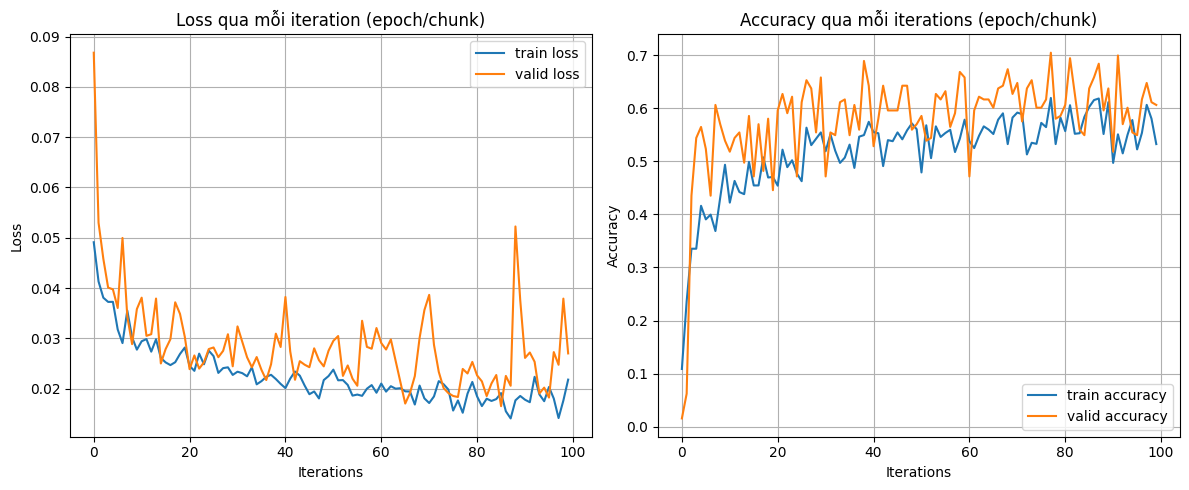

In [102]:
train_metrics = pd.read_csv(csv_log_path)

fig, axes = plt.subplots(1,2,figsize=(12,5))

train_losses = train_metrics['train_loss']
axes[0].plot(train_metrics['train_loss'], label='train loss')
axes[0].plot(train_metrics['val_loss'], label='valid loss')
axes[0].set_title("Loss qua mỗi iteration (epoch/chunk)")
axes[0].set_xlabel("Iterations")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(train_metrics['train_acc'], label='train accuracy')
axes[1].plot(train_metrics['val_acc'], label='valid accuracy')
axes[1].legend()
axes[1].set_title("Accuracy qua mỗi iterations (epoch/chunk)")
axes[1].set_xlabel("Iterations")
axes[1].set_ylabel("Accuracy")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [159]:
import torch

def confusion_matrix_from_ckpt(ckpt_path, data_loader, title):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ckpt_path = "experiments\\mobilenetv1_ham10k\\best_mobilenetv1_model.pth"
    ckpt = torch.load(ckpt_path, map_location=device)

    model.load_state_dict(ckpt)
    model.to(device)
    model.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 6))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=class_names,
    yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.show()

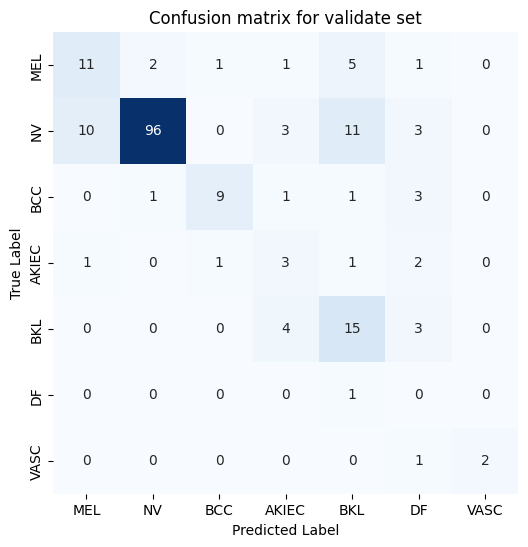

In [142]:
confusion_matrix_from_ckpt("experiments\\mobilenetv1_ham10k\\best_mobilenetv1_model.pth",valid_loader, "Confusion matrix for validate set")

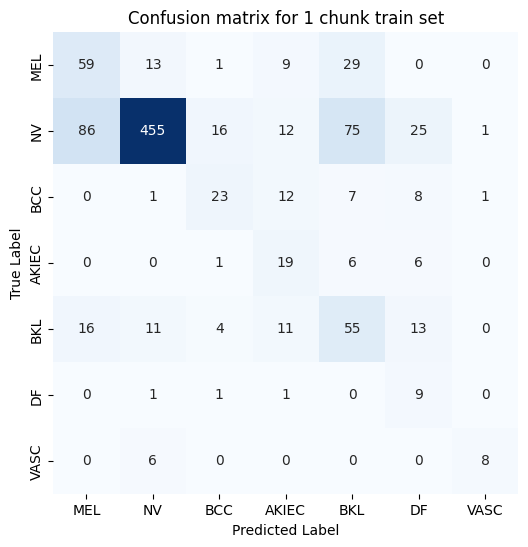

In [143]:
path = "D:\\HAM10k_with_DenseNet121\\experiments\\mobilenetv1_ham10k\\checkpoint"
path = os.path.join(path,os.listdir(path)[-1])

confusion_matrix_from_ckpt(path ,train_loader, "Confusion matrix for 1 chunk train set")

### 8.2 Mô hình suy luận trên tập test

In [ ]:
class TestDataset(Dataset):
    def __init__(self, img_dir, img_names, transform=None):
        self.img_dir = img_dir
        self.img_names = img_names
        self.transform = transform

    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self,idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, img_name
    
test_set = TestDataset(
    img_dir = x_test_path,
    img_names = os.listdir(x_test_path),
    transform=transform
)

test_loader = DataLoader(
    test_set,
    batch_size=32,
    shuffle=False
)

In [ ]:
test_loader = DataLoader(test_set)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ckpt = torch.load("experiments\\mobilenetv1_ham10k\\checkpoint\\epoch_10.pt",map_location=device)

model.load_state_dict(ckpt["model_state"])
model.to(device)
model.eval()

In [144]:
res = []

with torch.no_grad():
    for imgs, img_names in test_loader:
        imgs = imgs.to(device)

        output = model(imgs)
        probs = F.softmax(output, dim=1)
        confs, preds = torch.max(probs, dim=1)

        for img_name, pred, conf in zip(img_names, preds, confs):
            res.append({
                "img_id": img_name,
                "pred_class": int(pred.item()),
                "confidence": float(conf.item())
            })

df = pd.DataFrame(res)
df.to_csv("experiments\\mobilenetv1_ham10k\\test_pred\\test_preds.csv", index=False)

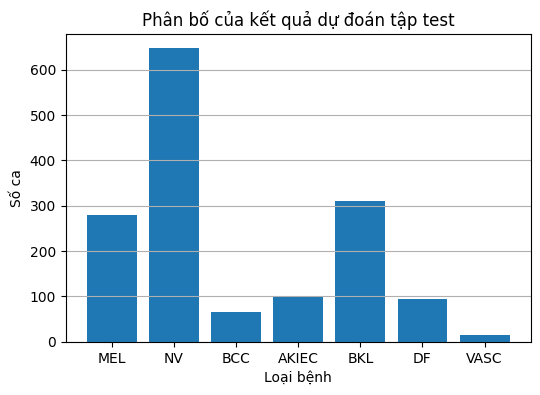

In [160]:
label_counts = df['pred_class'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(class_names, label_counts.values)
plt.xlabel("Loại bệnh")
plt.ylabel("Số ca")
plt.title("Phân bố của kết quả dự đoán tập test")
plt.grid(axis='y')
plt.show()

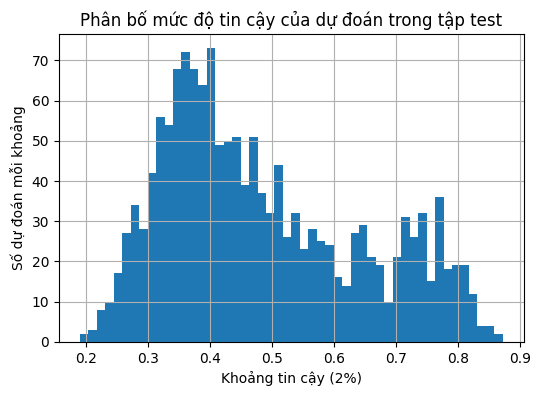

In [169]:
plt.figure(figsize=(6, 4))
plt.hist(df['confidence'], bins=50)
plt.xlabel("Khoảng tin cậy (2%)")
plt.ylabel("Số dự đoán mỗi khoảng")
plt.title("Phân bố mức độ tin cậy của dự đoán trong tập test")
plt.grid(True)
plt.show()